In [4]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt

# --------------------------
# Numba-accelerated functions
# --------------------------

@njit
def bullet_delays_numba(max_range, bv, step_mult=0.017):
    step = bv * step_mult
    delays = np.zeros(max_range + 1, dtype=np.float32)

    for d in range(1, max_range + 1):
        n = int(d // step)
        if n == 1:
            delay_ms = 33
        elif n > 1:
            delay_ms = 33 + (n - 1) * 17
        else:
            delay_ms = 0
        delays[d] = delay_ms / 1000.0

    return delays


@njit(parallel=True)
def simulate_real_ttk_numba(
    n_trials: int,
    hp: float,
    range_maxes: np.ndarray,
    damages: np.ndarray,
    fire_interval: float,
    first_shot_delay: float,
    body_mult: float,
    head_mult: float,
    base_accuracy: float,
    headshot_accuracy: float,
    delays: np.ndarray
):
    max_range = range_maxes[-1]
    results_mean   = np.zeros(max_range + 1, dtype=np.float32)
    results_median = np.zeros(max_range + 1, dtype=np.float32)
    results_p25    = np.zeros(max_range + 1, dtype=np.float32)
    results_p75    = np.zeros(max_range + 1, dtype=np.float32)
    results_clean  = np.zeros(max_range + 1, dtype=np.float32)

    # Pre-sample accuracies once per trial
    accuracies = np.clip(np.random.normal(loc=base_accuracy, scale=0.05, size=n_trials), 0.1, 1)

    for d in prange(max_range + 1):  # parallel over distances
        # Find damage for this distance
        dmg = 0.0
        for i in range(len(range_maxes)):
            if d <= range_maxes[i]:
                dmg = damages[i]
                break

        ttks = np.empty(n_trials, dtype=np.float32)
        delay = 0.0 if delays is None else delays[d]

        for trial in range(n_trials):
            shots = 0
            hp_left = hp
            time = first_shot_delay
            acc = accuracies[trial]

            while hp_left > 0:
                shots += 1
                rand_val = np.random.rand()

                if rand_val < acc:
                    if rand_val < headshot_accuracy:
                        damage = dmg * head_mult
                    else:
                        if np.random.rand() < 0.5:
                            damage = dmg * body_mult
                        else:
                            damage = dmg
                    hp_left -= damage

                if shots > 1:
                    time += fire_interval

            time += shots * delay  # bullet delay
            ttks[trial] = time

        results_mean[d]   = np.mean(ttks)
        results_median[d] = np.median(ttks)
        results_p25[d]    = np.percentile(ttks, 25)
        results_p75[d]    = np.percentile(ttks, 75)

        clean_shots = int(np.ceil(hp / (dmg * body_mult)))
        results_clean[d] = first_shot_delay + (clean_shots - 1) * fire_interval + (clean_shots * delay)

    return results_mean, results_median, results_p25, results_p75, results_clean


# --------------------------
# Python wrapper
# --------------------------

def simulate_real_ttk(
    n_trials: int,
    hp: float,
    damage_profile: list,       # [(range_max, damage), ...]
    fire_interval: float,
    t_ads: float = 0.0,
    t_stf: float = 0.0,
    sprinting: bool = False,
    body_mult: float = 1.1,
    head_mult: float = 1.5,
    base_accuracy: float = 0.20,
    headshot_accuracy: float = 0.02,
    bullet_speed: float = None,
    step_mult: float = 0.017,
):
    range_maxes = np.array([r for r, _ in damage_profile], dtype=np.int32)
    damages     = np.array([v for _, v in damage_profile], dtype=np.float32)

    delays = None
    if bullet_speed:
        delays = bullet_delays_numba(range_maxes[-1], bullet_speed, step_mult)

    first_shot_delay = (t_stf + t_ads) if sprinting else 0.0

    mean, median, p25, p75, clean = simulate_real_ttk_numba(
        n_trials=n_trials,
        hp=hp,
        range_maxes=range_maxes,
        damages=damages,
        fire_interval=fire_interval,
        first_shot_delay=first_shot_delay,
        body_mult=body_mult,
        head_mult=head_mult,
        base_accuracy=base_accuracy,
        headshot_accuracy=headshot_accuracy,
        delays=delays
    )

    # Convert to original dict-style output
    results = {}
    for d in range(range_maxes[-1] + 1):
        results[d] = {
            "mean":   float(mean[d]),
            "median": float(median[d]),
            "p25":    float(p25[d]),
            "p75":    float(p75[d]),
            "clean_ttk": float(clean[d]),
        }

    return list(range(range_maxes[-1] + 1)), results

def plot_ttk(gun_stats_dict, title="TTK vs Range", metric="median"):
    """
    gun_stats_dict: {"Gun Name": stats}, where stats is output from simulate_real_ttk
    metric: "mean" or "median" or "p25"/"p75"
    """
    plt.figure(figsize=(8,5))
    for gun_name, gun_info in gun_stats_dict.items():

        distances, stats = gun_info
        ttk_values = [stats[d][metric] for d in distances]
        plt.plot(distances, ttk_values, label=gun_name)
        if metric in ['median', 'mean']:
            lower = [stats[d]['p25'] for d in distances]
            upper = [stats[d]['p75'] for d in distances]
            plt.fill_between(distances, lower, upper, alpha=0.2)
    plt.xlim(0, 60*1.1)
    # plt.ylim(0.2,None)
    plt.xlabel("Range (m)")
    plt.ylabel(f"TTK ({metric}) [s]")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [2]:
# Set Seed
np.random.seed(42)

# Warm-up Numba
simulate_real_ttk(
    n_trials=500,
    hp=100,
    damage_profile=[(18, 28), (28.5, 24), (39, 21), (60, 17)],
    fire_interval=0.08,  # 750 RPM = 0.08 s between shots
    t_ads=0.261,
    t_stf=0.133,
    sprinting=False,
    body_mult=1.1,
    head_mult=1.5,
    bullet_speed=1247,    # m/s
);

In [3]:
# XM4
xm4 = simulate_real_ttk(
    n_trials=50000,
    hp=100,
    damage_profile=[(18, 28), (28.5, 24), (39, 21), (60, 17)],
    fire_interval=0.08,  # 750 RPM = 0.08 s between shots
    t_ads=0.261,
    t_stf=0.133,
    sprinting=False,
    body_mult=1.1,
    head_mult=1.5,
    bullet_speed=1247,    # m/s
)

# DR-H
drh = simulate_real_ttk(
    n_trials=50000,
    hp=100,
    damage_profile=[(18, 32), (24, 31), (30, 28), (43.2, 24), (60, 20)],
    fire_interval=0.105,  # 571 RPM = 0.105 s between shots
    t_ads=0.257,
    t_stf=0.150,
    sprinting=False,
    body_mult=1.15,
    head_mult=1.5,
)

In [5]:
# Guns Dict
guns = {
    "XM4": xm4,
    "DR-H":drh,
}

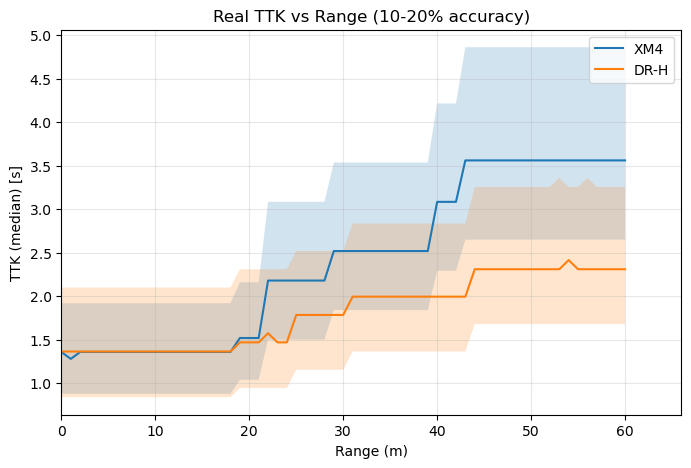

In [6]:
plot_ttk(guns, title="Real TTK vs Range (10-20% accuracy)", metric="median")